In [1]:
%load_ext  autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from trickster.search import a_star_search

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from scipy.spatial import distance
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

from defaultcontext import with_default_context
from profiled import Profiler, profiled

seed = 2018

## Load data

We assume the target linear model will work on one-hot discretized features. This is a common practice, since a linear model can only capture linear relationship between response and a continuous feature. If the continuous feature, however, is quantized, the relationship captured can be non-linear.

Therefore, we discretize and one-hot encode all features. We quantize the continuous features, like credit amount, age, etc., into 5 bins.

In [4]:
# Load the file
df = pd.read_csv('data/german_credit_data.csv')
df = df.drop(df.columns[0], axis=1) # remove the index column

# Quantize credit amount, duration and age into 5 bins
amount_series = df.loc[:, 'Credit amount']
df.loc[:, 'Credit amount'] = pd.qcut(amount_series, 5)

duration_series = df.loc[:, 'Duration']
df.loc[:, 'Duration'] = pd.qcut(duration_series, 5)

duration_series = df.loc[:, 'Age']
df.loc[:, 'Age'] = pd.qcut(duration_series, 5)

# Set Job type to object for one-hot encoding
df.loc[:, 'Job'] = df.loc[:, 'Job'].astype(object)

# Perform one-hot encoding
df = pd.get_dummies(df)
# Drop binary features
df = df.drop(columns=['Sex_male', 'Risk_bad'])

# Separate features from targets
df_X = df.iloc[:, :-1]
df_y = df.iloc[:, -1]

print('Examples are represented as {}-dimensional vectors.'.format(df_X.shape[1]))

Examples are represented as 38-dimensional vectors.


In [5]:
# Convert to numpy
X = df_X.values.astype('int8')
y = df_y.values.astype('int8')
print('Shape of X: {}. Shape of y: {}.'.format(X.shape, y.shape))

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

Shape of X: (1000, 38). Shape of y: (1000,).


((900, 38), (900,), (100, 38), (100,))

## Fit the target model

We start with an SVM-RBF just to see how much will we potentially lose by using plain logistic regression

In [6]:
# Fit SVM with RBF kernel using CV
tuned_parameters = [
    {
        'kernel': ['rbf'], 
        'gamma': [0.01, 0.03, 0.05, 0.07], 
        'C': [1, 3, 5, 7, 10]
    }
]
clf = GridSearchCV(SVC(), tuned_parameters, cv=5, n_jobs=-1)
clf.fit(X_train, y_train)
print('Best params are: {} with score: {:.2f}%.'.format(clf.best_params_, clf.best_score_ * 100))
print('Test score is: {:.2f}%.'.format(clf.score(X_test, y_test)*100))

# Best params are: {'C': 5, 'gamma': 0.03, 'kernel': 'rbf'} with score: 74.44%.
# Test score is: 71.00%.

Best params are: {'kernel': 'rbf', 'gamma': 0.03, 'C': 5} with score: 74.44%.
Test score is: 71.00%.


Now we fit the target logistic regression model.

In [7]:
# Fit logistic regression and perform CV
clf = LogisticRegressionCV(
    Cs=21, 
    cv=5, 
    n_jobs=-1, 
    random_state=seed
)
clf.fit(X_train, y_train)

# Get best score and C value
mean_scores = np.mean(clf.scores_[1], axis=0)
best_idx = np.argmax(mean_scores)
best_score = mean_scores[best_idx]
best_C = clf.Cs_[best_idx]

print('Best score is: {:.2f}%. Best C is: {:.4f}.'.format(best_score*100, best_C))
print('Test score is: {:.2f}%.'.format(clf.score(X_test, y_test)*100))

# Best score is: 73.44%. Best C is: 0.1585.
# Test score is: 71.000%.

Best score is: 73.44%. Best C is: 0.1585.
Test score is: 71.00%.


## Perform adversarial examples search

Context-local counter we'll use for counting expanded graph nodes.

In [8]:
@with_default_context(use_empty_init=True)
class Counter:
    def __init__(self):
        self.cnt = 0
        
    def increment(self):
        self.cnt += 1
        
    def count(self):
        return self.cnt

The `Node` class hosts the transformation code. By setting `decrease_amount` and `decrease_duration` we can get in total three different transformation graphs.

In [9]:
class Node:
    amount_start_idx = df_X.columns.get_loc("Credit amount_(249.999, 1262.0]")
    duration_start_idx = df_X.columns.get_loc("Duration_(3.999, 12.0]")
    purpose_start_idx = df_X.columns.get_loc("Purpose_business")
    
    def __init__(self, x, decrease_amount=True, decrease_duration=True):
        self.root = x
        self.decrease_amount = decrease_amount
        self.decrease_duration = decrease_duration
        
        # Slices in the vector for each features
        self.static = self.root[:Node.amount_start_idx]
        self.amount = self.root[Node.amount_start_idx:Node.duration_start_idx]
        self.duration = self.root[Node.duration_start_idx:Node.purpose_start_idx]
        self.purpose = self.root[Node.purpose_start_idx:]
    
    def _get_neighbour(self, x, direction='pos'):
        """Get the neighbouring value in a quantized one-hot feature vector."""
        idx = np.argmax(x)
        if direction == 'pos' and idx != len(x) - 1:
            return np.roll(x, 1).tolist()
        elif direction == 'neg' and idx != 0:
            return np.roll(x, -1).tolist()
        return []

    def _expand_neighbours(self, field, directions=None):
        """Expand neighbouring values of a quantized feature."""
        if directions is None:
            directions = ['pos', 'neg']
            
        child_fields = []
        for direction in directions:
            child_fields.append(self._get_neighbour(field, direction=direction))

        child_fields = [x for x in child_fields if len(x) > 0]
        return np.array(child_fields, dtype='uint8')
    
    def _expand_all(self, field):
        """Expand all values of a categorical feature."""
        child_fields = []
        for i in range(1, len(field)):
            child_fields.append(np.roll(field, i))
        return child_fields

    def expand(self):
        """Generate all children of the current node."""
        
        # Increment the counter of expanded nodes.
        counter = Counter.get_default()
        counter.increment()
        
        children = []
        
        # Expand "credit amount".
        for c in self._expand_neighbours(
                self.amount,
                directions=['pos', 'neg'] if self.decrease_amount else ['pos']):
            child = np.concatenate((self.static, c, self.duration, self.purpose))
            children.append(child)
        
        # Expand "duration".
        for c in self._expand_neighbours(
                self.duration,
                directions=['pos', 'neg'] if self.decrease_duration else ['pos']):
            child = np.concatenate((self.static, self.amount, c, self.purpose))
            children.append(child)
        
        # Expand "purpose".
        for c in self._expand_all(self.purpose):
            child = np.concatenate((self.static, self.amount, self.duration, c))
            children.append(child)
        return children
    
    def __repr__(self):
        return 'Node({})'.format(self.root)

All the functions that need to be passed into the search, in the expected format.

In [104]:
def _expand_fn(x, p_norm=1, **kwargs):
    """Wrap the example in `Node`, expand the node, and compute the costs.
    
    Returns a list of tuples (child, cost)
    """
    node = Node(x, **kwargs)
    children = node.expand()
    costs = [np.linalg.norm(x - c, ord=p_norm) for c in children]
    return list(zip(children, costs))

def _goal_fn(x, clf, target_confidence=0.5):
    """Tell whether the example has reached the goal."""
    return clf.predict_proba([x])[0, 1] >= target_confidence

def _heuristic_fn(x, clf, q_norm=np.inf):
    """Distance to the decision boundary of a logistic regression classifier.
    
    By default the distance is w.r.t. L1 norm. This means that the denominator
    has to be in terms of the Holder dual norm (`q_norm`), so L-inf. I know,
    this interface is horrible.
    
    NOTE: The value has to be zero if the example is already on the target side
    of the boundary.
    """
    score = clf.decision_function([x])[0]
    if score >= 0:
        return 0.0
    h = np.abs(score) / np.linalg.norm(
        clf.coef_[0, Node.amount_start_idx:], ord=q_norm)
    return h

def hash_fn(x):
    """Hash function for examples."""
    return hash(x.tostring())

@profiled
def find_adversarial(x, clf, p_norm=1, q_norm=np.inf,
                     target_confidence=0.5, return_path=False,
                     heuristic_fn=None, **kwargs):
    """Transform an example until it is classified with target confidence.""" 
    if heuristic_fn is None:
        heuristic_fn = lambda x: _heuristic_fn(x, clf, q_norm=q_norm)
    if clf.predict_proba([x])[0, 1] >= target_confidence:
        raise Exception('Initial example is already classified as positive.')        
    return a_star_search(
        start_node=x, 
        expand_fn=lambda x: _expand_fn(x, p_norm=p_norm, **kwargs), 
        goal_fn=lambda x: _goal_fn(x, clf, target_confidence), 
        heuristic_fn=heuristic_fn,
        hash_fn=hash_fn,
        return_path=return_path
    )

## Compare BFS to A*

In [105]:
def get_expanded_nodes_stats(p_norm=1, q_norm=np.inf):
    stats = pd.DataFrame(columns=['A*', 'BFS'])
    for i, x in enumerate(X):
        if clf.decision_function([x])[0] < 0:
            with Counter().as_default() as cnt_astar:
                find_adversarial(x, clf, p_norm=p_norm, q_norm=q_norm)

            with Counter().as_default() as cnt_bfs:
                find_adversarial(x, clf, p_norm=p_norm, q_norm=q_norm, heuristic_fn=lambda x: 0)

            stats.loc[i] = [cnt_astar, cnt_bfs]
    return stats

In [106]:
stats_l1 = get_expanded_nodes_stats(1, np.inf)
stats_l1

,A*,BFS
1,1,1
3,11,12
4,1,1
7,11,12
11,78,113
14,1,1
18,1,1
29,2,2
35,1,1
43,15,15


## Run the experiments

In [83]:
def find_adv_examples(X, target_confidence,
                      graph='all', p_norm=1, q_norm=np.inf,
                      heuristic=None):
    """Find adversarial examples for a whole dataset"""
    
    if graph == 'all':
        node_kwargs = dict(decrease_amount=True, decrease_duration=True)
    if graph == 'increase_amount':
        node_kwargs = dict(decrease_amount=False, decrease_duration=True)
    if graph == 'increase_amount_and_duration':
        node_kwargs = dict(decrease_amount=False, decrease_duration=False)
    
    # Dataframe for storing the results.
    results = pd.DataFrame(
        columns=['index', 'found', 'x_adv', 'confidence',
                 'real_cost', 'path_cost', 'nodes_expanded', 'runtime'])

    # Indices of examples classified as negative.
    neg_indices, = np.where(clf.predict_proba(X)[:, 1] < target_confidence)
    
    for i, original_index in enumerate(neg_indices):
        x = X[original_index]
        
        # Instantiate a counter for expanded nodes, and a profiler.
        expanded_counter = Counter()
        per_example_profiler = Profiler()
        
        with expanded_counter.as_default(), per_example_profiler.as_default():
            x_adv, path_cost = find_adversarial(
                x, clf, target_confidence=target_confidence, **node_kwargs)

        nodes_expanded = expanded_counter.count()
        runtime = per_example_profiler.compute_stats()['find_adversarial']['tot']
        
        # If an adversarial example was not found, only record index, runtime, and 
        # the number of expanded nodes.
        if x_adv is None:
            results.loc[i] = [original_index, False, [], None,
                              None, None, nodes_expanded, runtime]
        else:
            confidence = clf.predict_proba([x_adv])[0, 1]
            real_cost = np.linalg.norm(x - x_adv, ord=p_norm)
            
            results.loc[i] = [original_index, True, x_adv, confidence,
                              real_cost, path_cost, nodes_expanded, runtime]

    return results

Fix several target confidence levels.

In [84]:
confidence_levels = np.linspace(0.50, 0.95, 10)
confidence_levels

array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

Find adversarial examples for the whole dataset using different transformation graphs

In [85]:
results_graph_1 = []
for level in tqdm_notebook(confidence_levels):
    results_graph_1.append(find_adv_examples(X, level))

In [86]:
results_graph_2 = []
for level in tqdm_notebook(confidence_levels):
    results_graph_2.append(
        find_adv_examples(X, level, graph='increase_amount'))

In [87]:
results_graph_3 = []
for level in tqdm_notebook(confidence_levels):
    results_graph_3.append(
        find_adv_examples(X, level, graph='increase_amount_and_duration'))

## Sanity check for the optimality

This part was used for debugging. It checks the costs of the found adversarial examples for all three graphs. Since the second graph is a subgraph of the first, and the third is a subgraph of the second ($G_3 \subset G_2 \subset G_1$), the path cost of the adversarial examples has to follow $C(x, x^*_{G_3}) \geq C(x, x^*_{G_2}) \geq C(x, x^*_{G_1})$.

In [88]:
def example_diff(a, b):
    different_indices = np.where(a != b)
    return pd.DataFrame(
        [a[different_indices], b[different_indices]],
        columns=df_X.columns[different_indices],
    )

from IPython.display import display

In [89]:
for result_graph_1, result_graph_2, result_graph_3 in zip(
        results_graph_1, results_graph_2, results_graph_3):

    for i, x in enumerate(X):
        a = result_graph_1['path_cost'][result_graph_1['index'] == i].values
        b = result_graph_2['path_cost'][result_graph_2['index'] == i].values
        c = result_graph_3['path_cost'][result_graph_3['index'] == i].values

        try:
            if len(a) > 0 and len(b) > 0 and not pd.isna(a) and not pd.isna(b):
                assert a[0] <= b[0]
            if len(b) > 0 and len(c) > 0 and not pd.isna(b) and not pd.isna(c):
                assert b[0] <= c[0]
            if len(a) > 0 and len(c) > 0 and not pd.isna(a) and not pd.isna(c):
                assert a[0] <= c[0]
        
        # Output information about violating examples.
        except AssertionError:
            print('Assumption violated at index', i)
            print('Real costs:', a, b, c)
            
            path_a = result_graph_1['path_cost'][result_graph_1['index'] == i].values
            path_b = result_graph_2['path_cost'][result_graph_2['index'] == i].values
            path_c = result_graph_3['path_cost'][result_graph_3['index'] == i].values
            print('Path costs:', path_a, path_b, path_c)
            
            conf_a = result_graph_1['confidence'][result_graph_1['index'] == i].values[0]
            conf_b = result_graph_2['confidence'][result_graph_2['index'] == i].values[0]
            conf_c = result_graph_3['confidence'][result_graph_3['index'] == i].values[0]
            print('Confidences:', conf_a, conf_b, conf_c)
            
            x_adv_a = result_graph_1['x_adv'][result_graph_1['index'] == i].values[0]
            x_adv_b = result_graph_2['x_adv'][result_graph_2['index'] == i].values[0]
            x_adv_c = result_graph_3['x_adv'][result_graph_3['index'] == i].values[0]
            
            if len(x_adv_a) > 0:
                display(example_diff(X[i], x_adv_a))
            if len(x_adv_b) > 0:
                display(example_diff(X[i], x_adv_b))
            if len(x_adv_c) > 0:
                display(example_diff(X[i], x_adv_c))

            continue

### Plots

Success rates for crafting adversarial examples, and average confidence of these.

In [17]:
def plot_confidence(results):
    success_prop = [result['found'].mean() for result in results]
    avg_confidence = [result['confidence'].mean() for result in results]
    
    fig, ax = plt.subplots()
    ax.set_xticks(confidence_levels)
    ax.plot(confidence_levels, success_prop,
            label='Success proportion')
    ax.plot(confidence_levels, avg_confidence,
            label='Avg confidence of adversarial examples')
    ax.plot(confidence_levels, confidence_levels,
            linestyle='dashed', color='gray', label='Baseline confidence')
    ax.set_xlabel('Target confidence')
    ax.set_ylabel('')
    plt.legend()
    plt.show()

Graph 1 (changing "amount", "duration", and "purpose" in any direction)

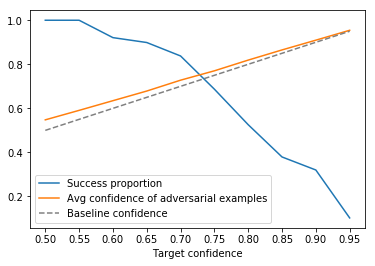

In [93]:
plot_confidence(results_graph_1)

Graph 2 (changing "duration" in any direction, and "purpose", and only increasing "amount")

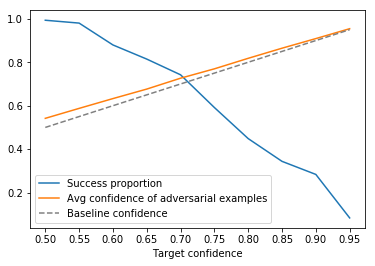

In [94]:
plot_confidence(results_graph_2)

Graph 3 (changing "purpose" in any direction, and only increasing "amount" and "duration")

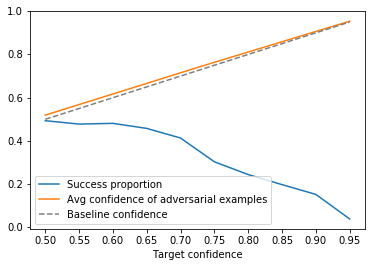

In [95]:
plot_confidence(results_graph_3)

Number of expanded nodes for graph 1 (strongly correlated with runtime)

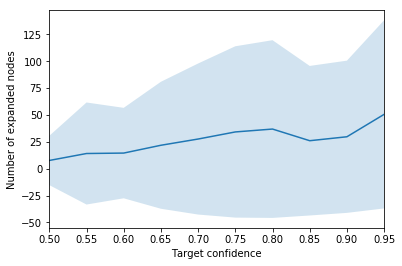

In [96]:
avg_expanded = pd.Series(
    [np.mean(result['nodes_expanded'][result['found']])
     for result in results_graph_1])
sigma_expanded = pd.Series(
    [np.std(result['nodes_expanded'][result['found']])
     for result in results_graph_1])

avg_runtime = pd.Series(
    [np.mean(result['runtime'][result['found']])
     for result in results_graph_1])

fig, ax = plt.subplots()
avg_expanded.plot(label='Number of expanded nodes', ax=ax)
ax.fill_between(range(len(confidence_levels)),
                avg_expanded - 2 * sigma_expanded,
                avg_expanded + 2 * sigma_expanded, alpha=.2)
ax.set_xticks(range(len(confidence_levels)))
ax.set_xticklabels(['%2.2f' % level for level in confidence_levels])
ax.set_xlim(0, len(confidence_levels) - 1)
ax.set_xlabel('Target confidence')
ax.set_ylabel('Number of expanded nodes')

# avg_runtime.plot(secondary_y=True, label='Avg runtime')
plt.show()